In [2]:
# Import required libs
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score, auc, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import lime
import lime.lime_tabular
import shap
pd.set_option("future.no_silent_downcasting", True)

In [3]:
# Read the dataset
dataset = pd.read_excel('esg-dataset.xlsx')

In [4]:
# Preview the dataset
dataset.head()

,Company,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Level,Controversy Score,ESG_Loan Approval
0,1,A,A,A,A,A,A,A,D,D,Moderate Controversy Level,2.0,High
1,2,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
2,3,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
3,4,B,B,A,A,A,C,A,A,A,None Controversy Level,NaN,High
4,5,B,B,D,A,A,A,A,A,C,Low Controversy Level,1.0,High


In [5]:
# Check the column names
dataset.columns

Index(['Company', 'EGroup1', 'EGroup2', 'EGroup3', 'EGroup4', 'Ggroup',
       'SGroup1', 'SGroup2', 'SGroup3', 'SGroup4', 'Controversy Level',
       'Controversy Score', 'ESG_Loan Approval'],
      dtype='object')

In [6]:
## Selecting the features and target variable
# Controversy Level and Controversy Score reflect the same infomation (highly correlated). So, we can drop one of them.
interested_features = ['EGroup1',
                       'EGroup2',
                       'EGroup3',
                       'EGroup4',
                       'Ggroup',
                       'SGroup1',
                       'SGroup2',
                       'SGroup3',
                       'SGroup4',
                       'Controversy Score']
target_var = 'ESG_Loan Approval'

## Exploratory Data Analysis

In [7]:
dataset_copy = dataset.copy()

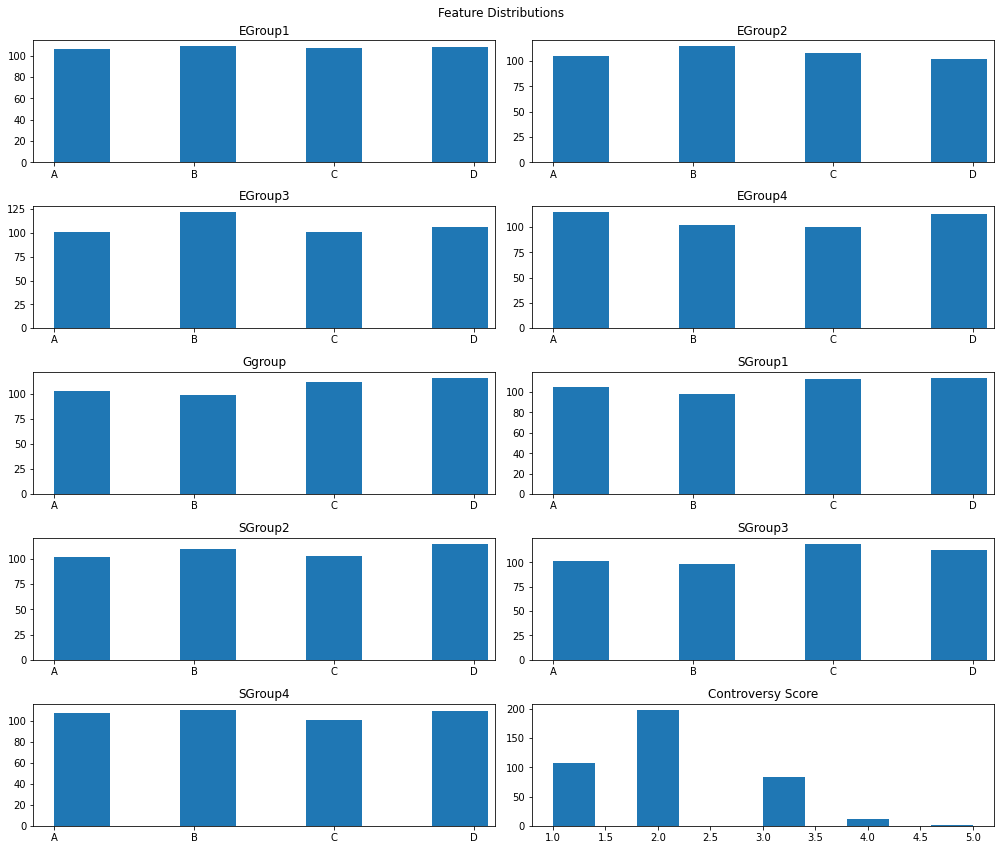

In [8]:
# Feature Distributions
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    ax = plt.subplot(5, 2, i+1)
    ax.hist(dataset_copy[feature].sort_values(), width = 0.4)
    ax.set_title(feature)
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

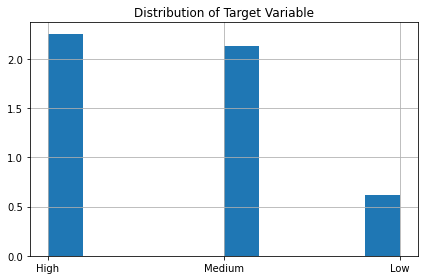

In [9]:
plt.figure()
dataset["ESG_Loan Approval"].hist(density = True)
plt.title("Distribution of Target Variable")
plt.tight_layout()
plt.show()

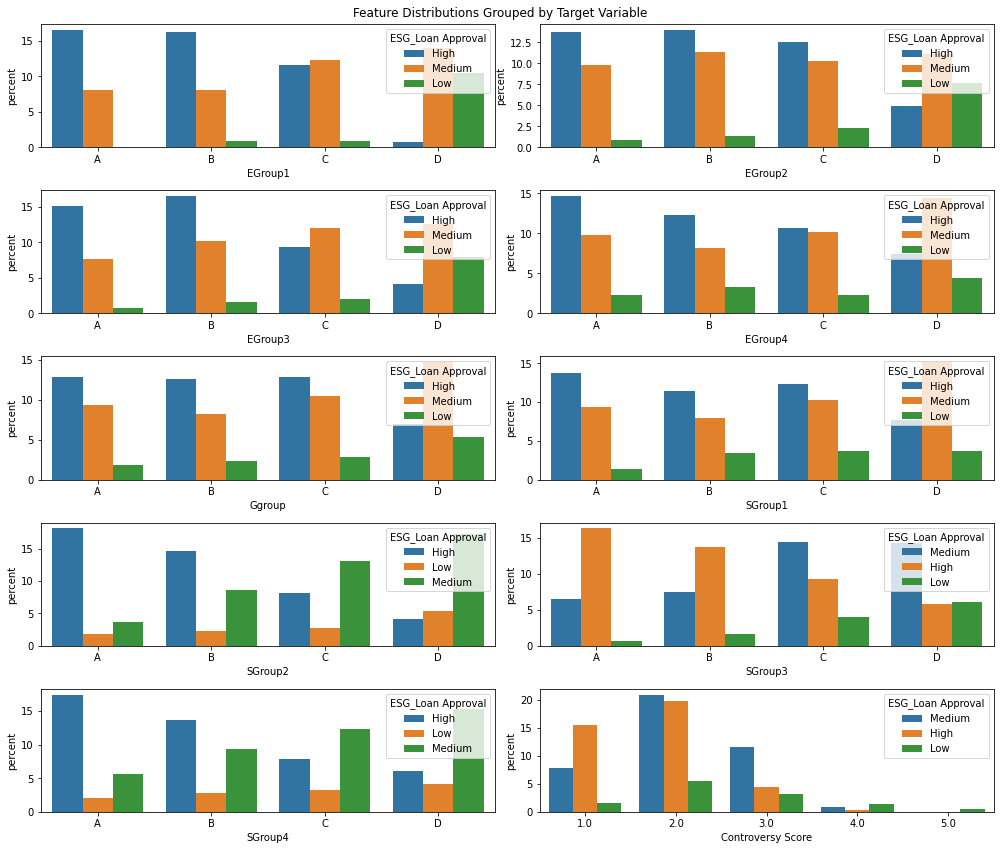

In [10]:
# Distribution of features grouping by target variable
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    plt.subplot(5, 2, i+1)
    dataset_copy = dataset_copy.sort_values(feature)
    sns.countplot(x=feature, data=dataset_copy, hue=target_var, stat = "percent")
plt.suptitle('Feature Distributions Grouped by Target Variable')
plt.tight_layout()
plt.show()

In [11]:
# transform str to int for correlation analysis
mapping = {"A": int(4), "B": int(3), "C": int(2), "D": int(1)}
for feature in interested_features:
    dataset_copy[feature] = dataset_copy[feature].replace(mapping)
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
dataset_copy["ESG_Loan Approval"]=dataset_copy["ESG_Loan Approval"].replace(target_map)

In [12]:
# exclude missing values for now
dataset_copy = dataset_copy.dropna()
# drop out the Contraversy Level column
dataset_copy = dataset_copy.drop(["Controversy Level"], axis=1)

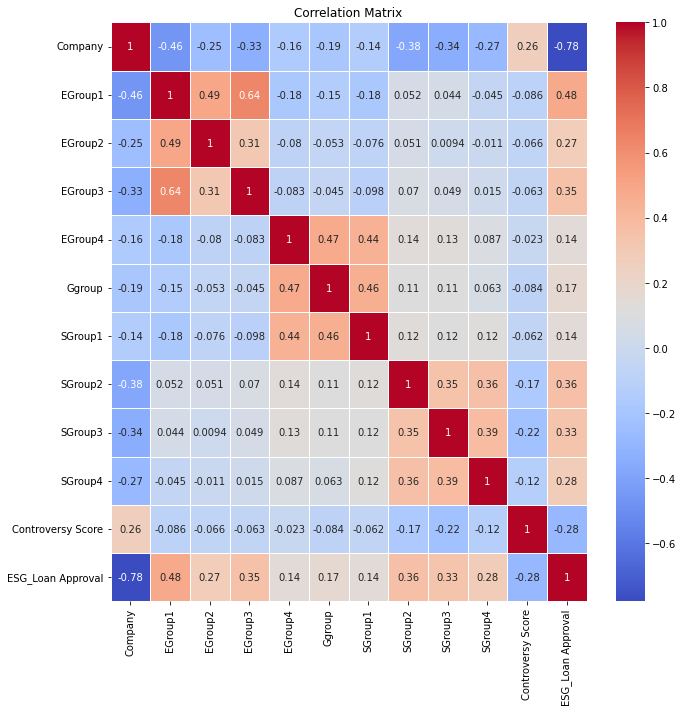

In [13]:
# Kenall Rank Correlation Matrix
corr = dataset_copy.corr(method='kendall')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Missing Value Detection and Filling

In [14]:
features = dataset[interested_features]
target = dataset[target_var]

In [15]:
# Numebr of sissing value in features
features.isnull().sum()

EGroup1               0
EGroup2               0
EGroup3               0
EGroup4               0
Ggroup                0
SGroup1               0
SGroup2               0
SGroup3               0
SGroup4               0
Controversy Score    27
dtype: int64

In [16]:
# Fill the controversy Score with the mode
mode = features["Controversy Score"].mode()[0]
features.loc[:,"Controversy Score"] = features["Controversy Score"].replace(np.nan, mode)

In [17]:
# Check the missing values again
features.isnull().sum()

EGroup1              0
EGroup2              0
EGroup3              0
EGroup4              0
Ggroup               0
SGroup1              0
SGroup2              0
SGroup3              0
SGroup4              0
Controversy Score    0
dtype: int64

## Data Transformation

In [18]:
features

,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Score
0,A,A,A,A,A,A,A,D,D,2.0
1,A,A,A,A,A,A,A,A,A,1.0
2,A,A,A,A,A,A,A,A,A,1.0
3,B,B,A,A,A,C,A,A,A,2.0
4,B,B,D,A,A,A,A,A,C,1.0
...,...,...,...,...,...,...,...,...,...,...
425,D,D,D,D,D,D,D,D,C,2.0
426,C,C,A,D,D,B,B,D,A,4.0
427,D,D,C,A,D,D,D,D,A,3.0
428,D,D,D,D,C,D,C,D,C,3.0


In [19]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features.loc[:,feature] = features[feature].replace(cat_mapping)
features = features.astype(int)

In [20]:
# Transform the target variable from categorical to numerical
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
target = target.replace(target_map).astype(int)

In [21]:
features["num_As"] = features[features.loc[:,cat_featrues]==3].count(axis=1)
features["num_Bs"] = features[features.loc[:,cat_featrues]==2].count(axis=1)
features["num_Cs"] = features[features.loc[:,cat_featrues]==1].count(axis=1)

## Modelling with SMOTE balance

In [22]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [23]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

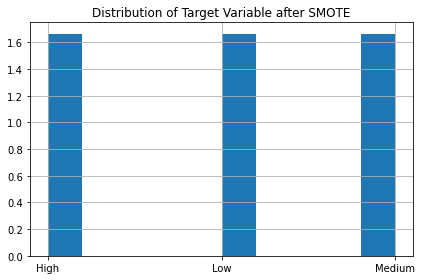

In [24]:
plt.figure()
y_train.replace({0:"Low", 1: "Medium", 2: "High"}).hist(density = True)
plt.title("Distribution of Target Variable after SMOTE")
plt.tight_layout()
plt.show()

# Best So Far
### Random Forest

In [25]:
# # Create a random forest regressor
# rf_classifier = RandomForestClassifier()
# # grid search for hyperparameters
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [5, 7, 10, 15, 20],
#     'min_samples_split': [2, 5, 10, 20],
#     'max_features' : ["auto", "sqrt", "log2"],
#     'class_weight': ['balanced', None],
#     'random_state': [11]
# }
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# # Get the best parameters
# best_params = grid_search.best_params_
# print(best_params)
# # Get the best model
# best_rf_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 480 candidates, totalling 3840 fits
{'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 50, 'random_state': 11}


In [ ]:
best_rf_classifier = RandomForestClassifier(class_weight='balanced', max_depth=15, max_features='auto', min_samples_split=5, n_estimators=50, random_state=11)

In [26]:
pred_train_rf = best_rf_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_rf)
prec_train = precision_score(y_train,pred_train_rf, average='macro')
recall_train = recall_score(y_train,pred_train_rf, average='macro')
f1_train = f1_score(y_train,pred_train_rf, average='macro')

pred_test_rf = best_rf_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_rf)
prec_test = precision_score(y_test,pred_test_rf, average='macro')
recall_test = recall_score(y_test,pred_test_rf, average='macro')
f1_test = f1_score(y_test,pred_test_rf, average='macro')

In [27]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9684
Train Precision: 0.9686
Train recall: 0.9684
Train f1-score: 0.9684
**********Test Phase**********
Test Acc: 0.8023
Test Precision: 0.8043
Test recall: 0.7312
Test f1-score: 0.7471


## Model performance evaluation

### Confusion Matrix

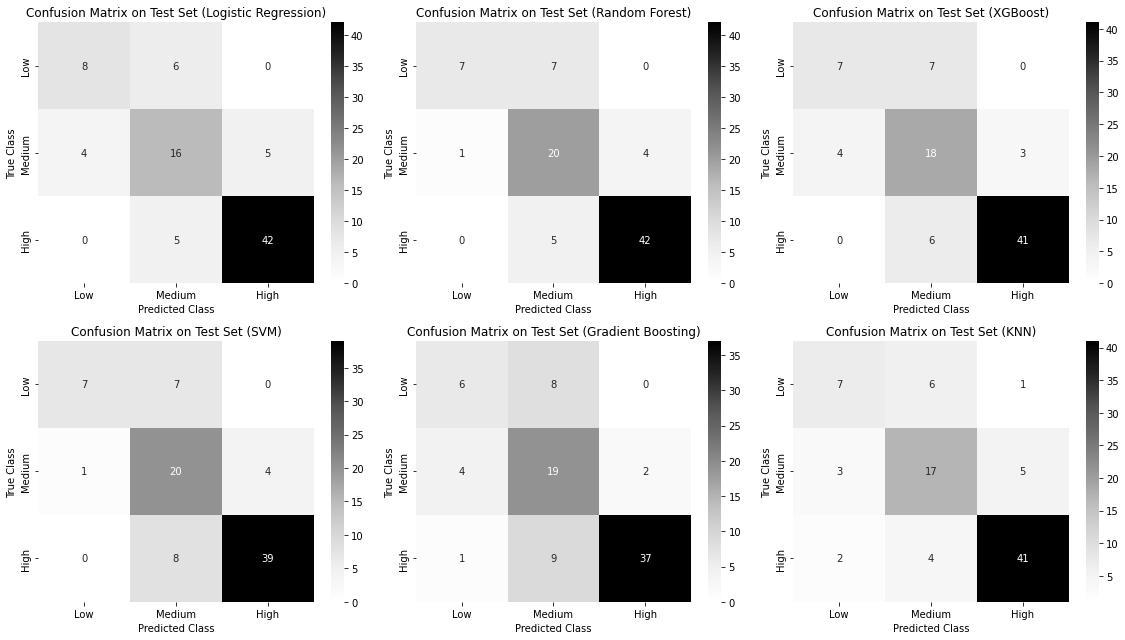

In [43]:
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}

plt.subplots(figsize=(16, 9))

ax2 = plt.subplot(1, 1, 1)
confMat=confusion_matrix(y_test, pred_test_rf)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax2=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax2.set_title('Confusion Matrix on Test Set (Random Forest)', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=10)
ax2.set_ylabel('True Class', fontsize=10)

plt.tight_layout()
plt.show()

### ROC-AUC curve

In [32]:

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_score = best_rf_classifier.predict_proba(X_test)
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.90


Text(0.5, 1.0, 'ROC Curve for Random Forest Classifier on the Test Set')

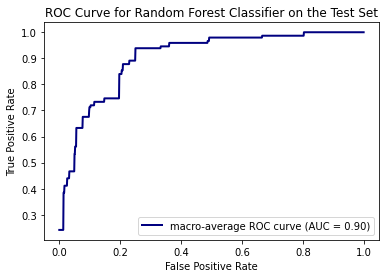

In [39]:
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linewidth=2,
)
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest Classifier on the Test Set")

## Interpretation (XAI)

In [44]:
correct_sample_indices = np.where(y_test==pred_test_rf)[0]
misclassified_sample_indices = np.where(y_test!=pred_test_rf)[0]
correct_sample = random.choice(correct_sample_indices)
misclassified_sample = random.choice(misclassified_sample_indices)

In [70]:
def local_explianer(model, X_train, X_test, y_test, y_pred_test, random=True, sample_indicies=None):
    if random:
        sample_indicies = [np.random.randint(0, X_test.shape[0])]
    else:
        if sample_indicies is None:
            raise ValueError("You have to assign a list or a int for 'sample_indicies' or set 'random' to True to randomly observe a sample.")
        else:
            sample_indicies = list(sample_indicies)
    y_test = np.array(y_test)        
    for sample in sample_indicies:
        print("*"*50)
        print("Generating local explanation for sample:{} ...".format(sample))
        pred_y = y_pred_test[sample]
        true_y = y_test[sample]
        print("True Labels: {:.2f}".format(true_y))
        print("Predicted Labels: {:.2f}".format(pred_y))

        plt.figure()
        plt.title("Local Explanation in Probability of Sample {} (True: {}, Pred.: {})".format(sample, int(true_y), int(pred_y)),fontsize=16)

        explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode="classification", feature_names=X_train.columns, discretize_continuous=False)
    
        local_exp = explainer.explain_instance(np.array(X_test)[sample], model.predict_proba, num_features=13)
        w_list = local_exp.as_list()
        name = [w_list[i][0].replace(".00", "") for i in range(len(w_list))]
        weight = [w_list[i][1] for i in range(len(w_list))]
        name, weight, abs_w = zip(*sorted(zip(name, weight, np.abs(weight)),key=lambda x: x[2], reverse=False))
        color = []
        for w in weight:
            if w<0:
                color.append("royalblue")
            else:
                color.append("orange")
                    
            plt.barh(name,weight,color=color)
            plt.grid(True, axis="x")
            plt.xlabel("Feature Weight")
            plt.ylabel("Feature Name")

**************************************************
Generating local explanation for sample:82 ...
True Labels: 2.00
Predicted Labels: 2.00
**************************************************
Generating local explanation for sample:51 ...
True Labels: 0.00
Predicted Labels: 1.00


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


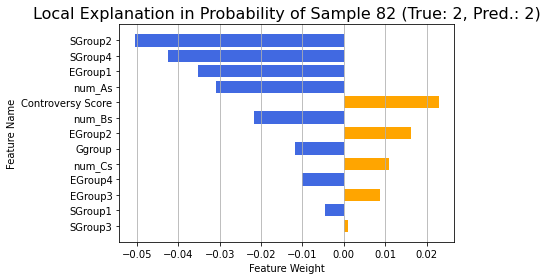

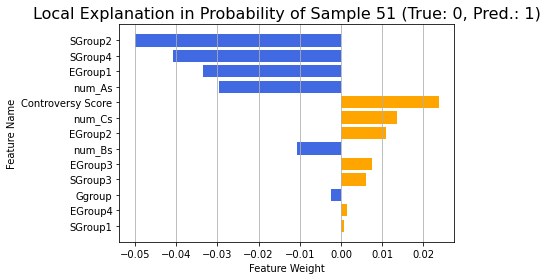

In [71]:
local_explianer(model=best_rf_classifier, X_train=X_train, X_test=X_test, y_test=y_test, y_pred_test = pred_test_rf, random=False, sample_indicies= [correct_sample, misclassified_sample])

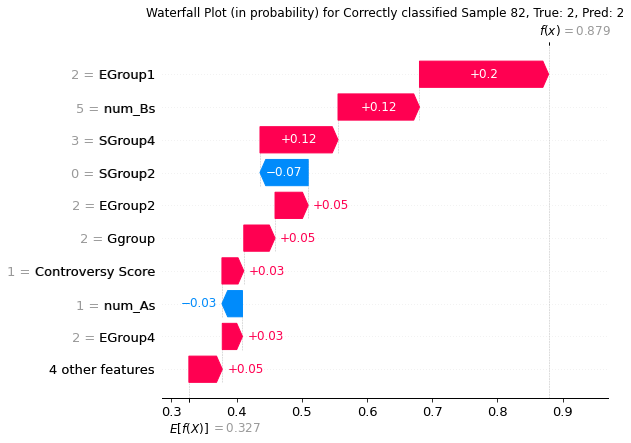

In [57]:
shap.initjs()
explainer = shap.TreeExplainer(best_rf_classifier)
shap_values = explainer(X_test)

# waterfall plot for the correct sample
plt.title("Waterfall Plot (in probability) for Correctly classified Sample {}, True: {}, Pred: {}".format(correct_sample, np.array(y_test)[correct_sample], pred_test_rf[correct_sample]))
shap.plots.waterfall(shap_values[correct_sample,:,best_rf_classifier.predict(X_test)[correct_sample]])

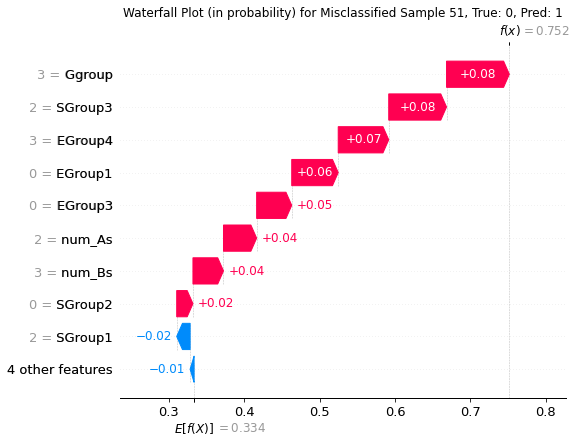

In [58]:
# waterfall plot for the misclassified sample
plt.title("Waterfall Plot (in probability) for Misclassified Sample {}, True: {}, Pred: {}".format(misclassified_sample, np.array(y_test)[misclassified_sample], pred_test_rf[misclassified_sample]))
shap.plots.waterfall(shap_values[misclassified_sample,:,best_rf_classifier.predict(X_test)[misclassified_sample]])